In [1]:
from dask.distributed import Client
import xml.etree.ElementTree as ET
import xarray
import requests
import re
import dask

import geopandas
import rioxarray as rio
import numpy
import pyproj
from pyproj import Transformer

#!pip install rasterstats
import rasterstats as rstats
from affine import Affine
import pyproj

# dask graph visualization
import graphviz 

from shapely.geometry import MultiPolygon
from cartopy.feature import ShapelyFeature
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

In [2]:
try:
    print(client.dashboard_link)
except:
    client = Client(n_workers=1, threads_per_worker=2, memory_limit='4GB')
    print(client.dashboard_link)

2023-05-02 13:59:47,635 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/6l/9spwppmn3gxfld10q9_szx5h0000gp/T/dask-worker-space/worker-zyeby7iv', purging


http://127.0.0.1:8787/status


---

### Collect Forcing Data - Subset and Save Locally

In [3]:
catalog_base_url = 'https://thredds.hydroshare.org/thredds/catalog'
dods_base_url = 'https://thredds.hydroshare.org/thredds/dodsC'
url = f'{catalog_base_url}/aorc/data/v1.1/16/catalog.xml'
root = ET.fromstring(requests.get(url).text)
ns = '{http://www.unidata.ucar.edu/namespaces/thredds/InvCatalog/v1.0}'


In [4]:
# use xpath top select all "dataset" elements.
elems = root.findall(f'.//{ns}dataset')

# loop through results and extract the "urlPath" attribute values
paths = []
for elem in elems:
    atts = elem.attrib
    if 'urlPath' in atts.keys():
        paths.append(f"{dods_base_url}/{atts['urlPath']}")
        
# use regex to isolate only files that end with ".nc"
paths = list(filter(re.compile("^.*\.nc$").match, paths))

In [5]:
ds = xarray.open_dataset(paths[0], chunks={'time': 10, 'x': 285, 'y':275})

ds_meta = xarray.open_dataset('http://thredds.hydroshare.org/thredds/dodsC/hydroshare/resources/2a8a3566e1c84b8eb3871f30841a3855/data/contents/WRF_Hydro_NWM_geospatial_data_template_land_GIS.nc')

leny = len(ds_meta.y)
x = ds_meta.x[373 : 1227 + 1].values
y = ds_meta.y[leny - 2405 - 1 : leny - 1586].values

X, Y = numpy.meshgrid(x, y)

# define the input crs
wrf_proj = pyproj.Proj(proj='lcc',
                       lat_1=30.,
                       lat_2=60., 
                       lat_0=40.0000076293945, lon_0=-97., # Center point
                       a=6370000, b=6370000) 

# define the output crs
wgs_proj = pyproj.Proj(proj='latlong', datum='WGS84')

# transform X, Y into Lat, Lon
transformer = pyproj.Transformer.from_crs(wrf_proj.crs, wgs_proj.crs)
lon, lat = transformer.transform(X, Y)

ds = ds.assign_coords(lon = (['y', 'x'], lon))
ds = ds.assign_coords(lat = (['y', 'x'], lat))
ds = ds.assign_coords(x = x)
ds = ds.assign_coords(y = y)

ds.x.attrs['axis'] = 'X'
ds.x.attrs['standard_name'] = 'projection_x_coordinate'
ds.x.attrs['long_name'] = 'x-coordinate in projected coordinate system'
ds.x.attrs['resolution'] = 1000.  # cell size

ds.y.attrs['axis'] = 'Y' 
ds.y.attrs['standard_name'] = 'projection_y_coordinate'
ds.y.attrs['long_name'] = 'y-coordinate in projected coordinate system'
ds.y.attrs['resolution'] = 1000.  # cell size

ds.lon.attrs['units'] = 'degrees_east'
ds.lon.attrs['standard_name'] = 'longitude' 
ds.lon.attrs['long_name'] = 'longitude'

ds.lat.attrs['units'] = 'degrees_north'
ds.lat.attrs['standard_name'] = 'latitude' 
ds.lat.attrs['long_name'] = 'latitude'

# add crs to netcdf file
ds.rio.write_crs(ds_meta.crs.attrs['spatial_ref'], inplace=True
                ).rio.set_spatial_dims(x_dim="x",
                                            y_dim="y",
                                            inplace=True,
                                           ).rio.write_coordinate_system(inplace=True)

# # sort data by valid_time
# ds = ds.sortby('valid_time')

# # create coordinate to allow loc searches
# ds = ds.assign_coords(time=('time', ds.valid_time.data))
# ds

<xarray.Dataset>
Dimensions:         (reference_time: 1, time: 744, x: 855, y: 820)
Coordinates:
    crs             int64 0
  * reference_time  (reference_time) datetime64[ns] 2010-01-01
  * time            (time) datetime64[ns] 2010-01-15T04:00:00 ... 2010-01-14
  * x               (x) float64 -1.93e+06 -1.929e+06 ... -1.077e+06 -1.076e+06
  * y               (y) float64 4.855e+05 4.845e+05 ... -3.325e+05 -3.335e+05
    lon             (y, x) float64 -121.4 -121.4 -121.4 ... -109.3 -109.3 -109.3
    lat             (y, x) float64 41.75 41.75 41.76 41.76 ... 36.15 36.15 36.16
Data variables:
    LQFRAC          (time, y, x) float64 dask.array<chunksize=(10, 275, 285), meta=np.ndarray>
    LWDOWN          (time, y, x) float64 dask.array<chunksize=(10, 275, 285), meta=np.ndarray>
    PSFC            (time, y, x) float64 dask.array<chunksize=(10, 275, 285), meta=np.ndarray>
    Q2D             (time, y, x) float64 dask.array<chunksize=(10, 275, 285), meta=np.ndarray>
    RAINRATE        (time, y, x) float32 dask.array<chunksize=(10, 275, 285), meta=np.ndarray>
    SWDOWN          (time, y, x) float64 dask.array<chunksize=(10, 275, 285), meta=np.ndarray>
    T2D             (time, y, x) float64 dask.array<chunksize=(10, 275, 285), meta=np.ndarray>
    U2D             (time, y, x) float64 dask.array<chunksize=(10, 275, 285), meta=np.ndarray>
    V2D             (time, y, x) float64 dask.array<chunksize=(10, 275, 285), meta=np.ndarray>
Attributes:
    model_output_valid_time:         2010-01-15_04:00:00
    model_initialization_time:       2010-01-01_00:00:00
    NWM_version_number:              v2.1
    model_configuration:             AORC
    model_output_type:               forcing
    model_total_valid_times:         744.0
    history:                         Wed Apr  5 16:20:19 2023: ncks /anvil/da...
    NCO:                             4.7.2
    DODS_EXTRA.Unlimited_Dimension:  time

Load shapefile from geodatabase

In [6]:
# prepare geometries for spatial averaging
polygons = geopandas.read_file('cat-679165/cat-679165_upstream_subset.gpkg', layer='divides')
target_crs = pyproj.Proj(proj='lcc',
                       lat_1=30.,
                       lat_2=60., 
                       lat_0=40.0000076293945, lon_0=-97., # Center point
                       a=6370000, b=6370000) 
# polygons = polygons.to_crs(target_crs.crs)
# mp = MultiPolygon([g for g in polygons.explode(index_parts=True).geometry])

# # get bounding box of all features
# xmin, ymin, xmax, ymax = mp.bounds

In [7]:
# read the geometries for plotting
shape_feature = ShapelyFeature(mp.geoms,
                                ccrs.PlateCarree(), facecolor='none')

NameError: name 'mp' is not defined

In [12]:
crs = str(shape_feature.crs)
crs

'+proj=eqc +ellps=WGS84 +a=6378137.0 +lon_0=0.0 +to_meter=111319.4907932736 +vto_meter=1 +no_defs +type=crs'

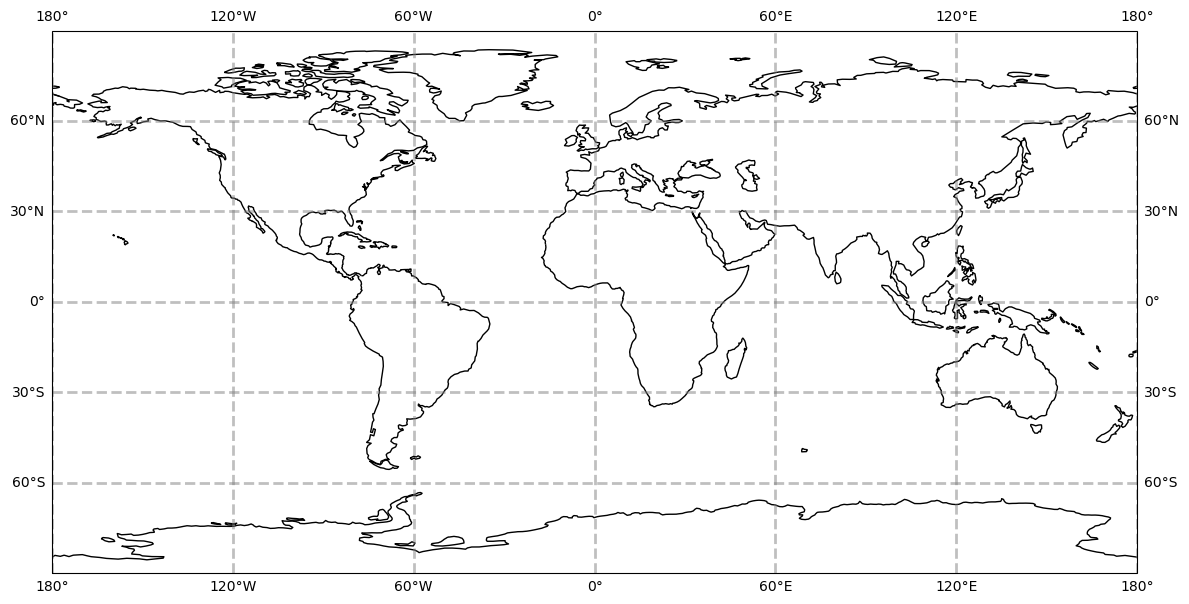

In [16]:
# plot the shapefile

plt.figure(figsize=(14, 14))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()

shape_feature = ShapelyFeature(mp.geoms,
                                ccrs.PlateCarree(), facecolor='none')
ax.add_feature(shape_feature)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--');

# # adjust the map boundary
# xmin, ymin, xmax, ymax = mp.bounds
# dx, dy = (0.1, 0.05)
# ax.set_ylim([ymin - dy, ymax + dy]);
# ax.set_xlim([xmin - dx, xmax + dx]);

ax.set_aspect('equal');
ax.coastlines();
plt.show()


In [17]:
# create a mask where lat/lon values in the AORC Dataset
# within the bounding box equals TRUE
x_padding = 1000
y_padding = 1000
mask_lon = (ds.x >= (xmin - x_padding)) & (ds.x <= (xmax + x_padding))
mask_lat = (ds.y >= (ymin - y_padding)) & (ds.y <= (ymax + y_padding))

In [18]:
# use the mask to subset the AORC data
ds = ds.where(mask_lon & mask_lat, drop=True)

In [ ]:
# visualize the subset using cartopy
plt.figure(figsize=(14, 14))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()

# shape_feature = ShapelyFeature(mp.geoms,
#                                 ccrs.PlateCarree(), facecolor='none')
# ax.add_feature(shape_feature, zorder=1)

# plot LWDOWN at the first timesteop
ds.isel(time=1).LWDOWN.plot(
      ax=ax, transform=ccrs.PlateCarree(), x="lon", y="lat",
     zorder=0)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--');
ax.set_ylim([41.4, 41.9]);
ax.set_xlim([-111.9, -111.3]);
ax.set_aspect('equal');
ax.coastlines();

In [6]:
@dask.delayed(nout=2)
def flipud(raster, affine):
    # https://github.com/perrygeo/python-rasterstats/issues/98
    raster = numpy.flipud(raster)
    affine = Affine(affine.a,
                    affine.b,
                    affine.c,
                    affine.d,
                    -1 * affine.e,
                    affine.f + (affine.e * (raster.shape[0] - 1)))
    return raster, affine

@dask.delayed
def spatial_average(timestep, catchment_id, variable, array_values, affine, polygon):
    
    # compute mean
#    mean_arr = rstats.zonal_stats(poly, array_values, affine=affine, stats="mean")
    mean_arr = 0
    return [timestep, catchment_id, variable, mean_arr]
    

@dask.delayed                                        
def get_array(ds, t, v):
    return ds.sel(time=t)[v].values
    

In [7]:
%%time

# compute affine via rioxarray. This will be upside down though.
affine = ds.rio.transform()



CPU times: user 56 ms, sys: 16.9 ms, total: 73 ms
Wall time: 91.2 ms


In [8]:
%%time
results = []
# loop through times
for t in ds.time[0:10]:
    # subset data for current time
    nc_arr = ds.sel(time=t)
    
    # loop through variabls
    for v in ['LQFRAC', 'LWDOWN', 'PSFC', 'Q2D', 'RAINRATE', 'SWDOWN', 'T2D', 'U2D', 'V2D']:
        
        # get data we're interested in 
        nc_arr = get_array(ds, t, v)
        
        # flip data
        nc_arr, affine = flipud(nc_arr, affine)
        
        for idx, row in polygons.iterrows():
            polygon = row.geometry
            
            # compute average
            results.append(spatial_average(t, row.id, v, nc_arr, affine, polygon))

   

CPU times: user 2 s, sys: 128 ms, total: 2.13 s
Wall time: 2.13 s


In [9]:
results[0].compute()

Task exception was never retrieved
future: <Task finished name='Task-1689' coro=<Client._gather.<locals>.wait() done, defined at /Users/castro/miniconda2/envs/ngen/lib/python3.11/site-packages/distributed/client.py:2176> exception=AllExit()>
Traceback (most recent call last):
  File "/Users/castro/miniconda2/envs/ngen/lib/python3.11/site-packages/distributed/client.py", line 2185, in wait
    raise AllExit()
distributed.client.AllExit


KeyboardInterrupt: 

2023-05-02 09:46:59,165 - distributed.nanny - ERROR - Worker process died unexpectedly
Process Dask Worker process (from Nanny):
Traceback (most recent call last):
  File "/Users/castro/miniconda2/envs/ngen/lib/python3.11/asyncio/runners.py", line 118, in run
    return self._loop.run_until_complete(task)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/castro/miniconda2/envs/ngen/lib/python3.11/asyncio/base_events.py", line 653, in run_until_complete
    return future.result()
           ^^^^^^^^^^^^^^^
  File "/Users/castro/miniconda2/envs/ngen/lib/python3.11/site-packages/distributed/nanny.py", line 946, in run
    await worker.finished()
  File "/Users/castro/miniconda2/envs/ngen/lib/python3.11/site-packages/distributed/core.py", line 503, in finished
    await self._event_finished.wait()
  File "/Users/castro/miniconda2/envs/ngen/lib/python3.11/asyncio/locks.py", line 213, in wait
    await fut
asyncio.exceptions.CancelledError

During handling of the above exception,

In [ ]:
res = client.gather(results)

In [72]:
res.compute()

AttributeError: 'list' object has no attribute 'compute'

In [50]:
nc_arr

Delayed('ndarray-e4bef009-e1ea-4fe2-b211-b22f5ab7d9e2')

In [327]:
 
# get data we're interested in 
nc_arr = ds.LWDOWN.sel(time="2010-01-01 00:00")

# get the values
nc_arr_vals = nc_arr.values

# compute affine via rioxarray. This will be upside down though.
affine = ds.rio.transform()

# correct the affine by flipping the NumPY array
nc_arr_vals, affine = flipud(nc_arr_vals, affine)

Convert ngen polygons into the AORC crs

In [338]:
import pyproj
target_crs = pyproj.Proj(proj='lcc',
                       lat_1=30.,
                       lat_2=60., 
                       lat_0=40.0000076293945, lon_0=-97., # Center point
                       a=6370000, b=6370000) 

projected_geoms = results.to_crs(target_crs.crs)

In [339]:
poly = list(projected_geoms['geometry'][0].geoms)[0]

Make sure that this polygon intersects with the AORC x, y dimension envelope

In [363]:
from shapely.geometry import Polygon, Point
xmin, xmax, ymin, ymax = (ds.x.min().item(),
                          ds.x.max().item(),
                          ds.y.min().item(),
                          ds.y.max().item())
aorc_bounds_poly = Polygon([(xmin,ymin),
                           (xmin,ymax),
                           (xmax,ymax),
                           (xmax,ymin),
                           (xmin, ymin)])
poly = list(projected_geoms['geometry'][0].geoms)[0]
aorc_bounds_poly.intersects(poly)

True

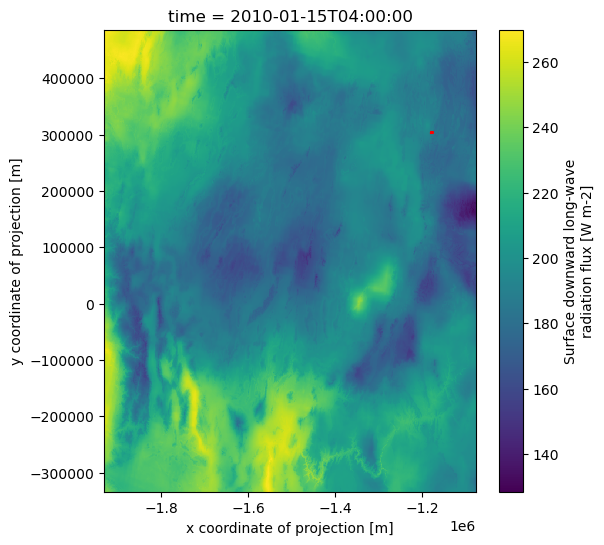

In [353]:
from rasterio.plot import show
from matplotlib import pyplot

fig, ax = pyplot.subplots(1, figsize=(6, 6))
ds.LWDOWN.isel(time=0).plot(ax=ax)

ax.plot(*poly.envelope.exterior.xy, color='red')
ax.plot(*poly2.envelope.exterior.xy, color='red')

In [360]:
mean_arr= rstats.zonal_stats(poly, nc_arr_vals, affine=affine, stats="mean")

In [361]:
mean_arr

[{'mean': 274.558}]